In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model, plot_model
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, BatchNormalization, Conv2D, MaxPool2D, Add, Input, Dropout
print('Tensorflow version =', tf.__version__)

Tensorflow version = 2.0.0-alpha0


## Loading the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()
print(f'Training samples = {x_train.shape[0]}')
print(f'Test samples = {x_test.shape[0]}')
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(labels)

Training samples = 50000
Test samples = 10000


## Visualizing some images
 - This is a a classic dataset containing 50000 images belonging to 10 differet categories
 - Our goal here is to perform supervised learning and classify a given image into 10 categories

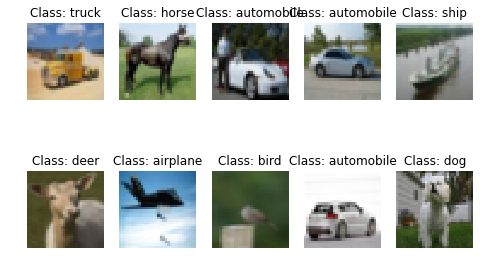

In [3]:
plt.subplots(2, 5, figsize=(8, 5))
for i, idx in enumerate(np.random.randint(0, len(x_train), 10)):
    plt.subplot(2, 5, i+1)
    plt.title(f'Class: {labels[y_train[idx][0]]}')
    plt.axis('off')
    plt.imshow(x_train[idx])

## Mean centering and scaling the dataset

In [4]:
x_test_disp = x_test.copy()
x_train = (x_train - x_train.mean(axis=0))/x_train.std(axis=0)
x_test = (x_test - x_test.mean(axis=0))/x_test.std(axis=0)

## Building the wide residual network using tf.keras
 ### Some points
  - Choosing WRN allows us to achieve better accuracy with a shallow model
  - MirroredStrategy for training to exploit data parallelism

In [5]:
def bn_relu(input_tensor):
    x = BatchNormalization(momentum=1e-1, epsilon=1e-5, gamma_initializer='uniform')(input_tensor)
    x = Activation('relu')(x)
    return x

def x_conv(input_tensor, nfilters, rate=2, strides=1):
    shortcut = Conv2D(filters=nfilters*rate, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(input_tensor)
    x = Conv2D(filters=nfilters*rate, kernel_size=3, strides=strides, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(input_tensor)
    x = bn_relu(x)
    x = Conv2D(filters=nfilters*rate, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(x)
    x = Add()([x, shortcut])
    return x

def wide_residual_block(input_tensor, nfilters, rate=2):
    shortcut = input_tensor
    x = bn_relu(input_tensor)
    x = Conv2D(filters=nfilters*rate, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(x)
    x = Dropout(0.4)(x)
    x = bn_relu(x)
    x = Conv2D(filters=nfilters*rate, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(x)
    x = Add()([x, shortcut])
    return x

def build_wrn():
    input_layer = Input(shape=(32, 32, 3))
    y = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(6e-4))(input_layer)

    y = bn_relu(y)
    y = x_conv(y, 16)

    for _ in range(4):
        y = wide_residual_block(y, 16)
    y = bn_relu(y)
    y = x_conv(y, 32, strides=2)

    for _ in range(4):
        y = wide_residual_block(y, 32)
    y = bn_relu(y)
    y = x_conv(y, 64, strides=2)

    for _ in range(4):
        y = wide_residual_block(y, 64)
    y = bn_relu(y)
    y = GlobalAveragePooling2D()(y)

    output_layer = Dense(10)(y)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

## Defining the training and evaluation loops
 - SparseCategoricalCrossentropy loss since out lables are not one hot encoded, using from_logits=True lets the loss function know that the model outputs are not scaled
 - Decorating a python function with tf.function() tell the tensorflow runtime to treat the function as a single computational graph
 - tf.GradientTape() keeps track of variables and actions performed on them under its scope, and thus helps us with differentiation

In [13]:
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

batch_size = 64
training_steps = x_train.shape[0]//batch_size
validation_steps = x_test.shape[0]//batch_size

def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    return tf.reduce_mean(loss)


@tf.function
def training_step(input_tensor, label_tensor):
    with tf.GradientTape() as Tape:
        logits = model(input_tensor, training=True)
        loss = loss_function(label_tensor, logits)
        acc = train_accuracy(label_tensor, logits)
    gradients = Tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc

@tf.function
def evaluation_step(input_tensor, label_tensor):
    with tf.GradientTape() as Tape:
        logits = model(input_tensor)
        acc = valid_accuracy(label_tensor, logits)
    return acc

## Training the model

In [7]:
model = build_wrn()
epochs = 50
loss_array = []
acc_array = []

for epoch in range(epochs):        
    for step in range(training_steps):
        img_tensor = np.float32(x_train[step*batch_size:(step+1)*batch_size])
        label_tensor = tf.reshape(y_train[step*batch_size:(step+1)*batch_size], shape=[-1, 1])
        
        loss, acc = training_step(img_tensor, label_tensor)
        loss_array.append(loss)
        acc_array.append(acc)
        if step % 350 == 0:
            print(f'| Loss at epoch_{epoch} step_{step} : {loss:.4f} |', f'acc : {acc:.3f} |')
model.save_weights('model_weights.h5')

| Loss at epoch_0 step_0 : 2.3040 | acc : 0.156 |
| Loss at epoch_0 step_350 : 2.0218 | acc : 0.258 |
| Loss at epoch_0 step_700 : 1.7034 | acc : 0.329 |
| Loss at epoch_1 step_0 : 1.7116 | acc : 0.343 |
| Loss at epoch_1 step_350 : 1.3927 | acc : 0.390 |
| Loss at epoch_1 step_700 : 1.2983 | acc : 0.427 |
| Loss at epoch_2 step_0 : 1.2530 | acc : 0.435 |
| Loss at epoch_2 step_350 : 1.0850 | acc : 0.462 |
| Loss at epoch_2 step_700 : 1.1950 | acc : 0.486 |
| Loss at epoch_3 step_0 : 1.0806 | acc : 0.491 |
| Loss at epoch_3 step_350 : 0.9048 | acc : 0.511 |
| Loss at epoch_3 step_700 : 1.0159 | acc : 0.528 |
| Loss at epoch_4 step_0 : 0.9556 | acc : 0.532 |
| Loss at epoch_4 step_350 : 0.8777 | acc : 0.547 |
| Loss at epoch_4 step_700 : 0.9831 | acc : 0.561 |
| Loss at epoch_5 step_0 : 0.8918 | acc : 0.564 |
| Loss at epoch_5 step_350 : 0.7240 | acc : 0.576 |
| Loss at epoch_5 step_700 : 0.8414 | acc : 0.587 |
| Loss at epoch_6 step_0 : 0.8117 | acc : 0.590 |
| Loss at epoch_6 step_350

## Plotting the train loss

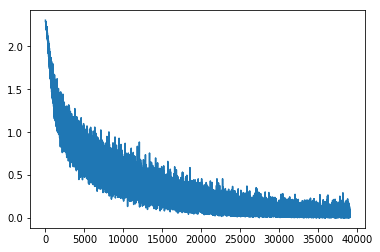

In [8]:
plt.plot(loss_array)

## Evaluating model on test dataset

In [20]:
val_acc_array = []
for step in range(validation_steps):
    img_tensor = np.float32(x_test[step*batch_size:(step+1)*batch_size])
    label_tensor = tf.reshape(y_test[step*batch_size:(step+1)*batch_size], shape=[-1, 1])
    acc = evaluation_step(img_tensor, label_tensor)
    val_acc_array.append(acc)
mean_accuracy = np.mean(val_acc_array)
print(f'| Validation accuracy : {mean_accuracy:.3f} |')

| Validation accuracy : 0.784 |


# Inference loop

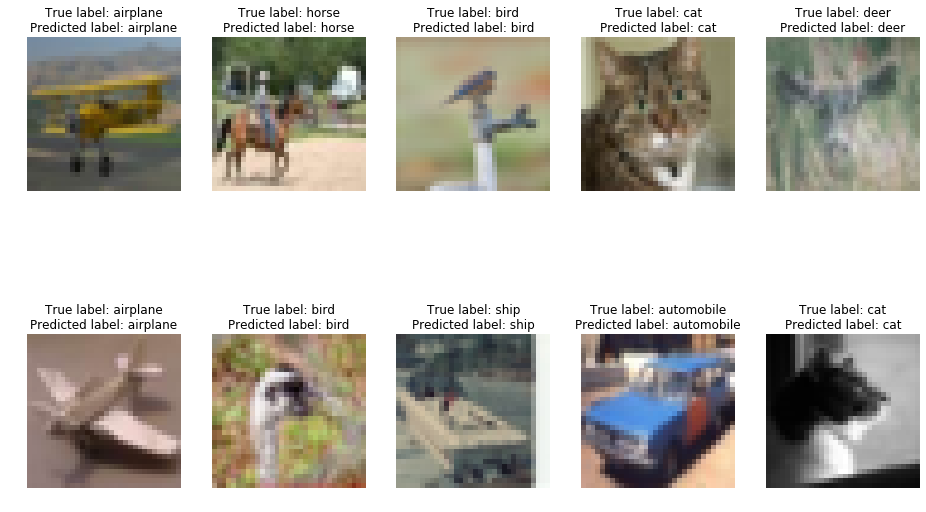

In [22]:
plt.subplots(2, 5, figsize=(16, 10))
for i, idx in enumerate(np.random.randint(0, len(x_test), 10)):
    img = np.float32(x_test[idx])
    pred_probs = np.squeeze(model(np.expand_dims(img, axis=0)))
    pred = labels[np.argmax(pred_probs)]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title(f'True label: {labels[y_test[idx][0]]}\nPredicted label: {pred}', wrap=True)
    plt.imshow(x_test_disp[idx])